In [1844]:
import numpy as np
import pandas as pd
from numpy import dot
from numpy.linalg import norm 
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from collections import Counter
import seaborn as sns

# Cleaning the data

In [1845]:
bgg = pd.read_csv('bgg_dataset_processed.csv', encoding='utf8')
bgg.head()

,ID,Name,Year Published,Min Players,Max Players,Play Time,Min Age,Users Rated,Rating Average,BGG Rank,Complexity Average,Owned Users,Mechanics,Domains
0,174430.0,Gloomhaven,2017.0,1,4,120,14,42055,879,1,386,68323.0,"Action Queue, Action Retrieval, Campaign / Bat...","Strategy Games, Thematic Games"
1,161936.0,Pandemic Legacy: Season 1,2015.0,2,4,60,13,41643,861,2,284,65294.0,"Action Points, Cooperative Game, Hand Manageme...","Strategy Games, Thematic Games"
2,224517.0,Brass: Birmingham,2018.0,2,4,120,14,19217,866,3,391,28785.0,"Hand Management, Income, Loans, Market, Networ...",Strategy Games
3,167791.0,Terraforming Mars,2016.0,1,5,120,12,64864,843,4,324,87099.0,"Card Drafting, Drafting, End Game Bonuses, Han...",Strategy Games
4,233078.0,Twilight Imperium: Fourth Edition,2017.0,3,6,480,14,13468,870,5,422,16831.0,"Action Drafting, Area Majority / Influence, Ar...","Strategy Games, Thematic Games"


In [1846]:
bgg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20343 entries, 0 to 20342
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   ID                  20327 non-null  float64
 1   Name                20343 non-null  object 
 2   Year Published      20342 non-null  float64
 3   Min Players         20343 non-null  int64  
 4   Max Players         20343 non-null  int64  
 5   Play Time           20343 non-null  int64  
 6   Min Age             20343 non-null  int64  
 7   Users Rated         20343 non-null  int64  
 8   Rating Average      20343 non-null  int64  
 9   BGG Rank            20343 non-null  int64  
 10  Complexity Average  20343 non-null  int64  
 11  Owned Users         20320 non-null  float64
 12  Mechanics           18744 non-null  object 
 13  Domains             10184 non-null  object 
dtypes: float64(3), int64(8), object(3)
memory usage: 2.2+ MB


There is one game which does not have a year listed. This game is 'Hus'. A quick Google search leads me to believe this game came out in ~1855, so I will add this in.

In [1847]:
bgg.loc[bgg['Name'] == 'Hus']

,ID,Name,Year Published,Min Players,Max Players,Play Time,Min Age,Users Rated,Rating Average,BGG Rank,Complexity Average,Owned Users,Mechanics,Domains
13984,NaN,Hus,NaN,2,2,40,0,38,628,13986,2,NaN,NaN,NaN


In [1848]:
bgg.at[13984, 'Year Published'] = 1855

Let us get rid of the entries which do not have any Owned Users

In [1849]:
nanOU = np.where(bgg['Owned Users'].isna())
bgg.iloc[nanOU][:3]

,ID,Name,Year Published,Min Players,Max Players,Play Time,Min Age,Users Rated,Rating Average,BGG Rank,Complexity Average,Owned Users,Mechanics,Domains
2828,202755.0,Guildhall Fantasy: Fellowship,2016.0,2,4,45,10,565,713,2830,200,NaN,"Hand Management, Take That, Set Collection",NaN
3590,196305.0,Guildhall Fantasy: Alliance,2016.0,2,4,45,10,360,720,3592,214,NaN,"Hand Management, Set Collection, Take That",NaN
3739,196306.0,Guildhall Fantasy: Coalition,2016.0,2,4,45,10,336,719,3741,213,NaN,"Hand Management, Set Collection, Take That",NaN


In [1850]:
bgg = bgg[bgg['Owned Users'].notna()]

Fill empty Mechanics cells with 'Not Mentioned' and empty Domains cells with 'Basic'

In [1851]:
nanM = np.where(bgg['Mechanics'].isna())
bgg.iloc[nanM][:3]

,ID,Name,Year Published,Min Players,Max Players,Play Time,Min Age,Users Rated,Rating Average,BGG Rank,Complexity Average,Owned Users,Mechanics,Domains
1059,85256.0,Timeline: Inventions,2010.0,2,8,15,8,7257,671,1060,111,12448.0,NaN,Family Games
1150,113401.0,Timeline: Events,2011.0,2,8,15,8,4208,678,1151,110,7924.0,NaN,"Family Games, Party Games"
1216,131325.0,Timeline: Diversity,2012.0,2,8,15,8,3790,679,1217,107,7589.0,NaN,"Family Games, Party Games"


In [1852]:
bgg["Mechanics"] = bgg["Mechanics"].fillna("Not Mentioned")
bgg["Domains"] = bgg["Domains"].fillna("Basic")

Clean up some of the issues in the Domains column

In [1853]:
bgg['Domains']=bgg['Domains'].apply(lambda x: x.replace(' Games', ''))
bgg['Domains']=bgg['Domains'].apply(lambda x: x.replace('games', ''))
bgg['Domains']=bgg['Domains'].apply(lambda x: x.replace(',', ''))

Find unique Domains

In [1854]:
unique_Domains = []
for i in range(len(bgg)):
    unique_Domains = unique_Domains + bgg.iat[i, 13].split()
    unique_Domains = list(set(unique_Domains))
print(unique_Domains)

['War', 'Customizable', 'Abstract', 'Basic', 'Strategy', 'Family', 'Thematic', 'Party', "Children's"]


Find unique Mechanics

In [1855]:
unique_Mechanics = []
for i in range(len(bgg)):
    unique_Mechanics = unique_Mechanics + bgg.iat[i, 12].split(', ')
    unique_Mechanics = list(set(unique_Mechanics))
print(unique_Mechanics)

['Line Drawing', 'Three Dimensional Movement', 'Square Grid', 'Re-rolling and Locking', 'Pattern Recognition', 'Negotiation', 'Minimap Resolution', 'Once-Per-Game Abilities', 'Grid Coverage', 'Turn Order: Role Order', 'Order Counters', 'Action/Event', 'Map Reduction', 'Not Mentioned', 'I Cut You Choose', 'Dice Rolling', 'Pattern Movement', 'Acting', 'Slide/Push', 'Communication Limits', 'Roll / Spin and Move', 'Player Judge', 'Deck Bag and Pool Building', 'Push Your Luck', 'Different Dice Movement', 'Paper-and-Pencil', 'Hot Potato', 'Random Production', 'Market', 'Area-Impulse', 'Events', 'Die Icon Resolution', 'Bias', 'Predictive Bid', 'Layering', 'Measurement Movement', 'Action Timer', 'Impulse Movement', 'Zone of Control', 'Auction: Sealed Bid', 'Hexagon Grid', 'Selection Order Bid', 'Cube Tower', 'Secret Unit Deployment', 'Interrupts', 'Ownership', 'Auction: Fixed Placement', 'Tug of War', 'Turn Order: Random', 'Semi-Cooperative Game', 'King of the Hill', 'Different Worker Types', 

This is too many Mechanics. Categorical encoding will lead to overfitting with this many columns, so plan is to find most frequent mechanics and place all others into a category titled 'Infrequent Mechanics'

In [1856]:
#Code to get Corpus
def Get_Corpus(bla):
    corpus= []
    for i in bla:
        item = i.split(",")
        corpus += item
    return corpus
#Code to delete extra space
def space_eleminator(list):
    vals=[]
    for i in list:
        m = i.lstrip()
        vals.append(m)
    return vals

Mechanics_corpus = space_eleminator(Get_Corpus(bgg["Mechanics"]))
Mechs_dic = Counter(Mechanics_corpus)

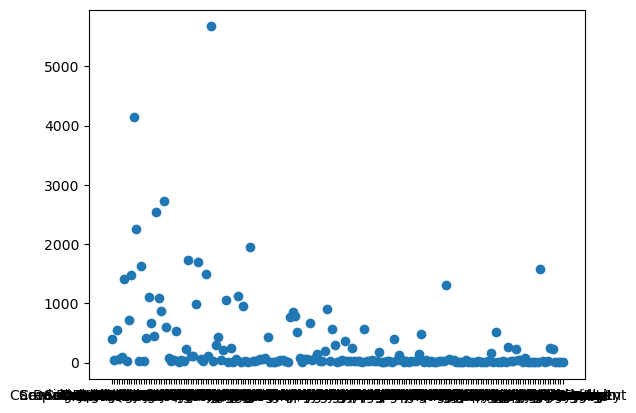

In [1857]:
Item_M = list(Mechs_dic.keys())
Freq_M = list(Mechs_dic.values())
plt.scatter(Item_M, Freq_M)
plt.show()

In [1858]:
frequent_Mechanics = []
infrequent_Mechanics = []
for i in range(len(Freq_M)):
    if (Freq_M[i] > 1000):
        frequent_Mechanics = frequent_Mechanics + [Item_M[i]]
    else:
        infrequent_Mechanics = infrequent_Mechanics + [Item_M[i]]
print(frequent_Mechanics)

['Cooperative Game', 'Grid Movement', 'Hand Management', 'Hexagon Grid', 'Modular Board', 'Simultaneous Action Selection', 'Variable Player Powers', 'Action Points', 'Set Collection', 'Card Drafting', 'Tile Placement', 'Area Majority / Influence', 'Dice Rolling', 'Auction/Bidding', 'Area Movement', 'Simulation', 'Roll / Spin and Move', 'Not Mentioned']


These are the 18 most frequent mechanics. Let us strip all the others away.

In [1859]:
for i in range(len(bgg)):
    l = bgg.iat[i, 12].split(', ')
    for j in range(len(l)):
        if l[j] in infrequent_Mechanics:
            l[j] = 'Infrequent Mechanics'
    l = list(set(l))
    bgg.iat[i, 12] = ', '.join(l)
bgg.head()

,ID,Name,Year Published,Min Players,Max Players,Play Time,Min Age,Users Rated,Rating Average,BGG Rank,Complexity Average,Owned Users,Mechanics,Domains
0,174430.0,Gloomhaven,2017.0,1,4,120,14,42055,879,1,386,68323.0,"Hexagon Grid, Hand Management, Infrequent Mech...",Strategy Thematic
1,161936.0,Pandemic Legacy: Season 1,2015.0,2,4,60,13,41643,861,2,284,65294.0,"Hand Management, Infrequent Mechanics, Coopera...",Strategy Thematic
2,224517.0,Brass: Birmingham,2018.0,2,4,120,14,19217,866,3,391,28785.0,"Hand Management, Infrequent Mechanics",Strategy
3,167791.0,Terraforming Mars,2016.0,1,5,120,12,64864,843,4,324,87099.0,"Hexagon Grid, Hand Management, Infrequent Mech...",Strategy
4,233078.0,Twilight Imperium: Fourth Edition,2017.0,3,6,480,14,13468,870,5,422,16831.0,"Hexagon Grid, Dice Rolling, Infrequent Mechani...",Strategy Thematic


Let us drop the columns we do not need.

In [1860]:
bgg = bgg.drop(columns = ['ID'], axis=1)
bgg = bgg.reset_index(drop=True)
bgg.head()

,Name,Year Published,Min Players,Max Players,Play Time,Min Age,Users Rated,Rating Average,BGG Rank,Complexity Average,Owned Users,Mechanics,Domains
0,Gloomhaven,2017.0,1,4,120,14,42055,879,1,386,68323.0,"Hexagon Grid, Hand Management, Infrequent Mech...",Strategy Thematic
1,Pandemic Legacy: Season 1,2015.0,2,4,60,13,41643,861,2,284,65294.0,"Hand Management, Infrequent Mechanics, Coopera...",Strategy Thematic
2,Brass: Birmingham,2018.0,2,4,120,14,19217,866,3,391,28785.0,"Hand Management, Infrequent Mechanics",Strategy
3,Terraforming Mars,2016.0,1,5,120,12,64864,843,4,324,87099.0,"Hexagon Grid, Hand Management, Infrequent Mech...",Strategy
4,Twilight Imperium: Fourth Edition,2017.0,3,6,480,14,13468,870,5,422,16831.0,"Hexagon Grid, Dice Rolling, Infrequent Mechani...",Strategy Thematic


Let us check for correlations between traits in the data

<AxesSubplot:>

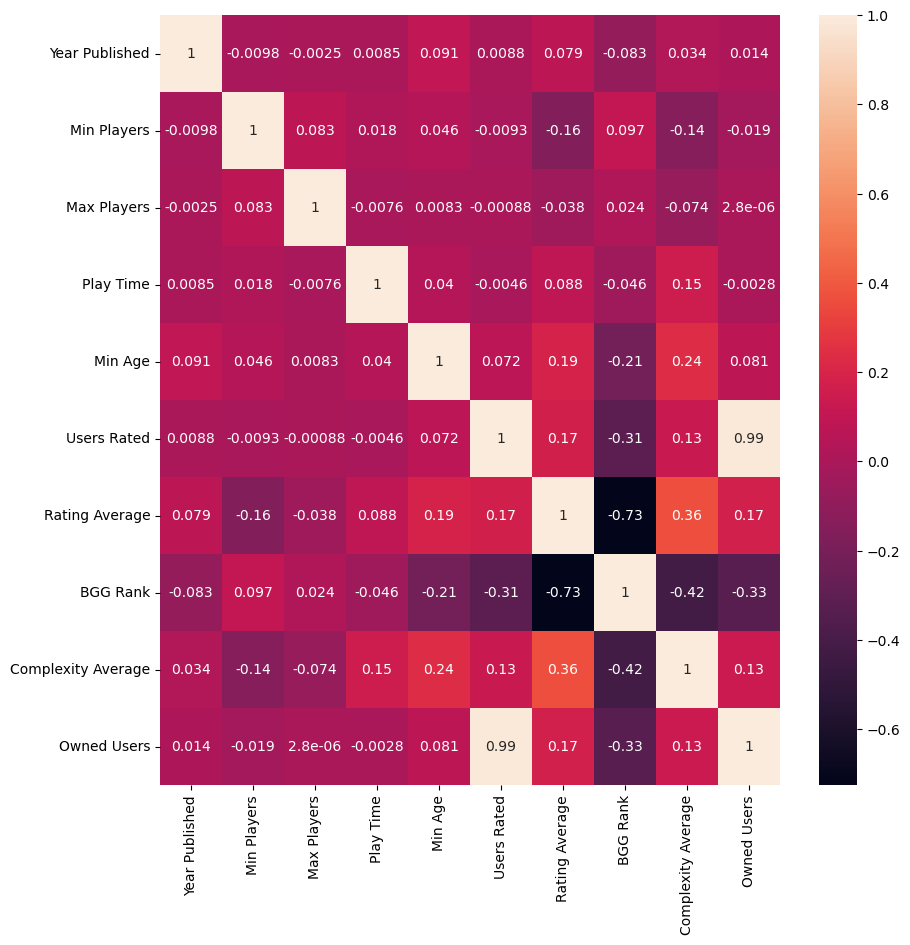

In [1861]:
corr_df = bgg.drop(columns = ['Mechanics', 'Domains'], axis=1)
corrmat= corr_df.corr()
plt.figure(figsize=(10,10))  
sns.heatmap(corrmat,annot=True)

It looks like Users Rated and Owned Users are highly correlated. Let's plot them to see.

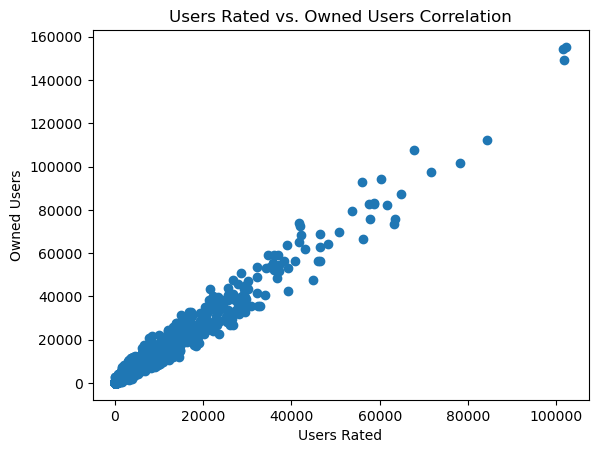

In [1862]:
x = bgg['Users Rated'].values
y = bgg['Owned Users'].values
plt.scatter(x, y)
plt.title('Users Rated vs. Owned Users Correlation')
plt.xlabel('Users Rated')
plt.ylabel('Owned Users')
plt.show()

To deal with this, I will simply remove one of these variables, so as to not inflate the weight of its influence.

In [1863]:
bgg = bgg.drop(columns=['Owned Users'], axis=1)

Let us now check for outliers and normalize the features.

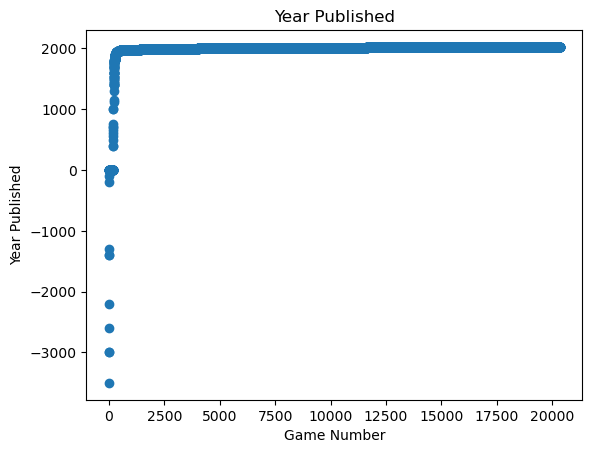

In [1864]:
x = bgg['BGG Rank'].values
y = sorted(bgg['Year Published'].values)
plt.scatter(x, y)
plt.title('Year Published')
plt.xlabel('Game Number')
plt.ylabel('Year Published')
plt.show()

Let us perform a percentile linearization to this column to help this issue.

In [1865]:
size = len(bgg['Year Published'])-1
bgg['Year Published'] = bgg['Year Published'].rank(method='min').apply(lambda x: (x-1)/size)

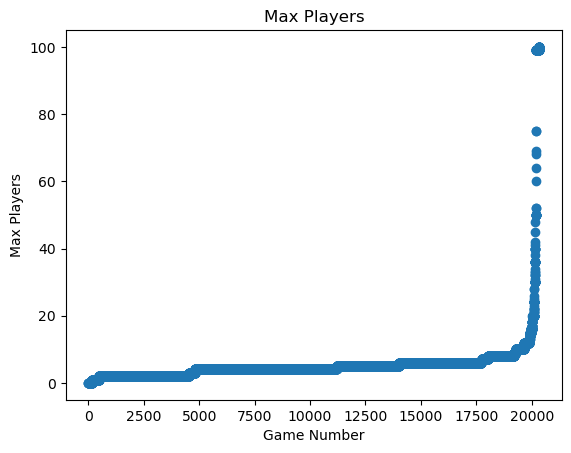

In [1870]:
x = bgg['BGG Rank'].values
y = sorted(bgg['Max Players'].values)
plt.scatter(x, y)
plt.title('Max Players')
plt.xlabel('Game Number')
plt.ylabel('Max Players')
plt.show()

Let us perform a truncation to the higher values, to reduce the spread.

In [1869]:
bgg['Max Players'] = bgg['Max Players'].apply(lambda x: min(x,100))

In [1806]:
def normalize_features(data):
    scaler = StandardScaler()
    scaler.fit(data)
    data_norm = scaler.transform(data)
    return data_norm

def normalize(data):
    '''
    This function will normalize the input data to be between 0 and 1
    
    params:
        data (List) : The list of values you want to normalize
    
    returns:
        The input data normalized between 0 and 1
    '''
    min_val = min(data)
    data = [x - min_val for x in data]
    max_val = max(data)
    return [x/max_val for x in data]

def ohe(df, enc_col, delim):
    '''
    This function will one hot encode the specified column and add it back
    onto the input dataframe
    
    params:
        df (DataFrame) : The dataframe you wish for the results to be appended to
        enc_col (String) : The column you want to OHE
        delim (String) : The delimiter separating traits
    
    returns:
        The OHE columns added onto the input dataframe
    '''
    
    ohe_df = df[enc_col].str.get_dummies(delim)
    ohe_df.reset_index(drop = True, inplace = True)
    return pd.concat([df, ohe_df], axis = 1).drop(columns=[enc_col], axis=1)

def cosine_sim(v1, v2, weight = 1):
    '''
    This function will calculate the cosine similarity between two vectors, with a weight
    '''
    return weight * dot(v1,v2)/(norm(v1)*norm(v2))

In [1807]:
# one-hot-encode Domains and Mechanics
bgg = ohe(bgg, 'Mechanics', ', ')
bgg = ohe(bgg, 'Domains', ' ')

In [1808]:
# normalize all continuous features
bgg['Year Published'] = normalize(bgg['Year Published'].values)
bgg['Min Players'] = normalize(bgg['Min Players'].values)
bgg['Max Players'] = normalize(bgg['Max Players'].values)
bgg['Play Time'] = normalize(bgg['Play Time'].values)
bgg['Min Age'] = normalize(bgg['Min Age'].values)
bgg['Users Rated'] = normalize(bgg['Users Rated'].values)
bgg['Rating Average'] = normalize(bgg['Rating Average'].values)
bgg['BGG Rank'] = normalize(bgg['BGG Rank'].values)
bgg['Complexity Average'] = normalize(bgg['Complexity Average'].values)

bgg.head()

,Name,Year Published,Min Players,Max Players,Play Time,Min Age,Users Rated,Rating Average,BGG Rank,Complexity Average,...,Variable Player Powers,Abstract,Basic,Children's,Customizable,Family,Party,Strategy,Thematic,War
0,Gloomhaven,0.779221,0.1,0.004004,0.002,0.56,0.411268,0.917277,0.000000,0.782961,...,1,0,0,0,0,0,0,1,1,0
1,Pandemic Legacy: Season 1,0.661844,0.2,0.004004,0.001,0.52,0.407236,0.898429,0.000049,0.576065,...,1,0,0,0,0,0,0,1,1,0
2,Brass: Birmingham,0.841872,0.2,0.004004,0.002,0.56,0.187769,0.903665,0.000098,0.793103,...,0,0,0,0,0,0,0,1,0,0
3,Terraforming Mars,0.717506,0.1,0.005005,0.002,0.48,0.634483,0.879581,0.000147,0.657201,...,1,0,0,0,0,0,0,1,0,0
4,Twilight Imperium: Fourth Edition,0.779221,0.3,0.006006,0.008,0.56,0.131508,0.907853,0.000197,0.855984,...,1,0,0,0,0,0,0,1,1,0


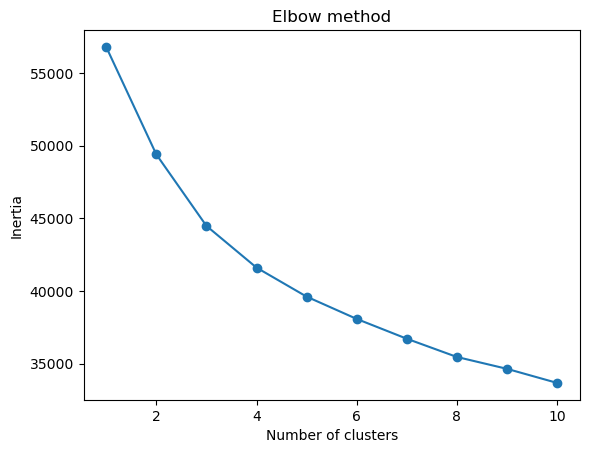

In [1809]:
inertias = []

for i in range(1,11):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(bgg.drop(columns='Name'))
    inertias.append(kmeans.inertia_)

plt.plot(range(1,11), inertias, marker='o')
plt.title('Elbow method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

In [1674]:
kmeans = KMeans(n_clusters=9)
kmeans.fit(bgg.drop('Name', axis=1))

KMeans(n_clusters=9)

In [1675]:
bgg['Cluster Number'] = kmeans.labels_

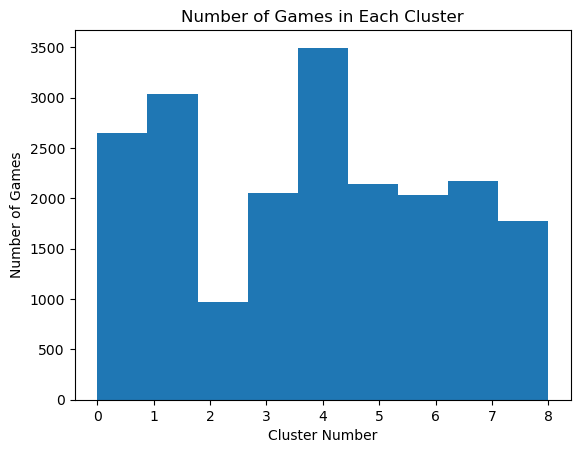

In [1676]:
plt.hist(kmeans.labels_, bins=9)
plt.title('Number of Games in Each Cluster')
plt.xlabel('Cluster Number')
plt.ylabel('Number of Games')
plt.show()

In [1677]:
bgg.loc[bgg['Cluster Number'] == 0].mean(axis=0)

C:\Users\possu\AppData\Local\Temp\ipykernel_720\3199202566.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  bgg.loc[bgg['Cluster Number'] == 0].mean(axis=0)


Year Published                   0.992331
Min Players                      0.210204
Max Players                      0.006643
Play Time                        0.000706
Min Age                          0.356825
Users Rated                      0.001067
Rating Average                   0.613660
BGG Rank                         0.689357
Complexity Average               0.207928
Action Points                    0.025321
Area Majority / Influence        0.043084
Area Movement                    0.023054
Auction/Bidding                  0.053288
Card Drafting                    0.077475
Cooperative Game                 0.065004
Dice Rolling                     0.000000
Grid Movement                    0.022676
Hand Management                  0.000000
Hexagon Grid                     0.006425
Infrequent Mechanics             0.000000
Modular Board                    0.044974
Not Mentioned                    0.418745
Roll / Spin and Move             0.126228
Set Collection                   0

Recently released average rated basic games.

In [1678]:
bgg.loc[bgg['Cluster Number'] == 1].mean(axis=0)

C:\Users\possu\AppData\Local\Temp\ipykernel_720\1639429195.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  bgg.loc[bgg['Cluster Number'] == 1].mean(axis=0)


Year Published                   0.995181
Min Players                      0.177409
Max Players                      0.003247
Play Time                        0.005103
Min Age                          0.406537
Users Rated                      0.002285
Rating Average                   0.713701
BGG Rank                         0.468737
Complexity Average               0.541008
Action Points                    0.064124
Area Majority / Influence        0.044393
Area Movement                    0.134166
Auction/Bidding                  0.002960
Card Drafting                    0.012167
Cooperative Game                 0.007563
Dice Rolling                     0.680039
Grid Movement                    0.178889
Hand Management                  0.024334
Hexagon Grid                     0.665242
Infrequent Mechanics             0.523512
Modular Board                    0.043736
Not Mentioned                    0.002302
Roll / Spin and Move             0.004933
Set Collection                   0

Recently released well-rated war games.

In [1679]:
bgg.loc[bgg['Cluster Number'] == 2].mean(axis=0)

C:\Users\possu\AppData\Local\Temp\ipykernel_720\4051280869.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  bgg.loc[bgg['Cluster Number'] == 2].mean(axis=0)


Year Published                   0.997572
Min Players                      0.176161
Max Players                      0.005106
Play Time                        0.001654
Min Age                          0.466378
Users Rated                      0.025576
Rating Average                   0.721291
BGG Rank                         0.220442
Complexity Average               0.490148
Action Points                    0.173375
Area Majority / Influence        0.065015
Area Movement                    0.125903
Auction/Bidding                  0.015480
Card Drafting                    0.090815
Cooperative Game                 0.327141
Dice Rolling                     0.654283
Grid Movement                    0.170279
Hand Management                  0.262126
Hexagon Grid                     0.034056
Infrequent Mechanics             0.804954
Modular Board                    0.282766
Not Mentioned                    0.000000
Roll / Spin and Move             0.049536
Set Collection                   0

Recently released well received but low-rank thematic games.

In [1680]:
bgg.loc[bgg['Cluster Number'] == 3].mean(axis=0)

C:\Users\possu\AppData\Local\Temp\ipykernel_720\1614635711.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  bgg.loc[bgg['Cluster Number'] == 3].mean(axis=0)


Year Published                   0.992849
Min Players                      0.184919
Max Players                      0.006465
Play Time                        0.000965
Min Age                          0.378077
Users Rated                      0.001316
Rating Average                   0.670717
BGG Rank                         0.584823
Complexity Average               0.261746
Action Points                    0.094192
Area Majority / Influence        0.073694
Area Movement                    0.057589
Auction/Bidding                  0.022938
Card Drafting                    0.069790
Cooperative Game                 0.126403
Dice Rolling                     1.000000
Grid Movement                    0.092240
Hand Management                  0.143485
Hexagon Grid                     0.022450
Infrequent Mechanics             0.601269
Modular Board                    0.129819
Not Mentioned                    0.000000
Roll / Spin and Move             0.093704
Set Collection                   0

Recently released basic dice-rolling games.

In [1681]:
bgg.loc[bgg['Cluster Number'] == 4].mean(axis=0)

C:\Users\possu\AppData\Local\Temp\ipykernel_720\224225181.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  bgg.loc[bgg['Cluster Number'] == 4].mean(axis=0)


Year Published                   0.992421
Min Players                      0.223284
Max Players                      0.007231
Play Time                        0.000917
Min Age                          0.384085
Users Rated                      0.001315
Rating Average                   0.652002
BGG Rank                         0.601050
Complexity Average               0.235439
Action Points                    0.028890
Area Majority / Influence        0.054920
Area Movement                    0.028032
Auction/Bidding                  0.083810
Card Drafting                    0.076373
Cooperative Game                 0.083810
Dice Rolling                     0.000000
Grid Movement                    0.030034
Hand Management                  0.000000
Hexagon Grid                     0.007151
Infrequent Mechanics             1.000000
Modular Board                    0.061499
Not Mentioned                    0.000000
Roll / Spin and Move             0.078375
Set Collection                   0

Recently released basic non-dice rolling games.

In [1682]:
bgg.loc[bgg['Cluster Number'] == 5].mean(axis=0)

C:\Users\possu\AppData\Local\Temp\ipykernel_720\74084760.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  bgg.loc[bgg['Cluster Number'] == 5].mean(axis=0)


Year Published                   0.984475
Min Players                      0.212605
Max Players                      0.006022
Play Time                        0.000501
Min Age                          0.296657
Users Rated                      0.007072
Rating Average                   0.617760
BGG Rank                         0.599025
Complexity Average               0.257877
Action Points                    0.010271
Area Majority / Influence        0.033613
Area Movement                    0.024743
Auction/Bidding                  0.014006
Card Drafting                    0.018674
Cooperative Game                 0.034547
Dice Rolling                     0.107843
Grid Movement                    0.082166
Hand Management                  0.043417
Hexagon Grid                     0.007003
Infrequent Mechanics             0.525677
Modular Board                    0.053221
Not Mentioned                    0.169001
Roll / Spin and Move             0.121849
Set Collection                   0

In [1643]:
df.loc[df['Cluster Number'] == 6]

,Name,Cluster Number
1,Pandemic Legacy: Season 1,6
2,Brass: Birmingham,6
3,Terraforming Mars,6
6,Through the Ages: A New Story of Civilization,6
7,Gaia Project,6
...,...,...
20015,The Prince: The Struggle of House Borgia,6
20166,Fallen City of Karez,6
20168,Tom Clancy's Politika,6
20227,Hengist,6


In [1644]:
df.loc[df['Cluster Number'] == 7]

,Name,Cluster Number
92,Codenames,7
101,Decrypto,7
130,The Resistance: Avalon,7
158,Captain Sonar,7
162,Just One,7
...,...,...
20315,War,7
20316,Bingo,7
20317,Candy Land,7
20318,Chutes and Ladders,7


In [1645]:
df.loc[df['Cluster Number'] == 8]

,Name,Cluster Number
1047,Exit: The Game - The Sinister Mansion,8
1092,Exit: The Game - The Forgotten Island,8
1108,Exit: The Game - The Sunken Treasure,8
1260,Exit: The Game - The Mysterious Museum,8
1440,Exit: The Game - The Catacombs of Horror,8
...,...,...
20243,Urban Myth,8
20244,The Game of Life (40th Anniversary Edition),8
20250,The Lord of the Rings: The Fellowship of the Ring,8
20258,Coaster Park,8


In [ ]:
class CBRecommend():
    def __init__(self, df):
        self.df = df
    
    def recommend(self, game_names, n_rec):
        """
        df (dataframe): The dataframe
        game_names (List): Representing the game names
        n_rec (int): amount of rec user wants
        """
        
        # calculate similarity of input game_name vectors w.r.t all other vectors
        no_name = self.df.drop(columns='Name')
        self.df['Similarity'] = np.zeros(len(self.df))
        for i in range(len(game_names)):
            game_id = int(bgg.loc[bgg['Name'] == game_names[i]].index.values)
            inputVec = no_name.iloc[game_id]
            no_name = no_name.drop(game_id)
            self.df = self.df.drop(game_id)
            self.df['Similarity'] = self.df['Similarity'] + no_name.apply(lambda x: cosine_sim(inputVec, x.values), axis=1)
        self.df['Similarity'] = self.df['Similarity'] / len(game_names)

        # returns top n user specified games
        n_best = self.df.nlargest(columns='Similarity', n=n_rec)
        return n_best[['Name', 'Similarity']]

In [1813]:
# ran on a sample as an example
t = bgg.copy()
cbr = CBRecommend(df = t)
print(cbr.recommend(game_names = ['Arkham Horror: The Card Game', 'Spirit Island', 'Everdell', '7 Wonders Duel',
                                  'Pandemic Legacy: Season 1', '7 Wonders', 'Pandemic Legacy: Season 0',
                                  'Pandemic Legacy: Season 2', 'Root', 'Splendor', 'Stone Age'], n_rec = 10))

                              Name  Similarity
10             Great Western Trail    0.725610
2                Brass: Birmingham    0.720562
22   Viticulture Essential Edition    0.720226
18               Brass: Lancashire    0.717899
36                       Maracaibo    0.717282
190                    Viticulture    0.715063
84              Dominion: Intrigue    0.714542
42               Underwater Cities    0.714288
333                     Innovation    0.712792
314                         Gùgōng    0.711979
